# Motivating figure

In [69]:
import jax
import datagen
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

## Process sample

In [3]:
key = jax.random.PRNGKey(314)

In [62]:
delta = 1.0
dynamics_covariance = 0.1
obs_covariance = 1.0
outlier_scale = 2.0
dgen = datagen.GaussMeanOutlierMovingObject2D(
    delta, dynamics_covariance, obs_covariance,
    outlier_proba=0.0,
    outlier_scale=outlier_scale,
)


In [63]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 20
dataset = dgen.sample(key, initial_mean, n_steps)

measurements_clean = dataset["observed"]
state = dataset["latent"]

xout = jnp.array([5, 10, 15])

measurements = measurements_clean[xout] * outlier_scale * jnp.array([-1, 1, -1])[:, None]
measurements = measurements_clean.at[xout].set(measurements)

In [179]:
ix = 1
y = measurements[:, ix]
yout = y[xout]

xrange = jnp.arange(n_steps)
is_outlier = jnp.isin(xrange, xout)

Text(0.5, 0, 'time')

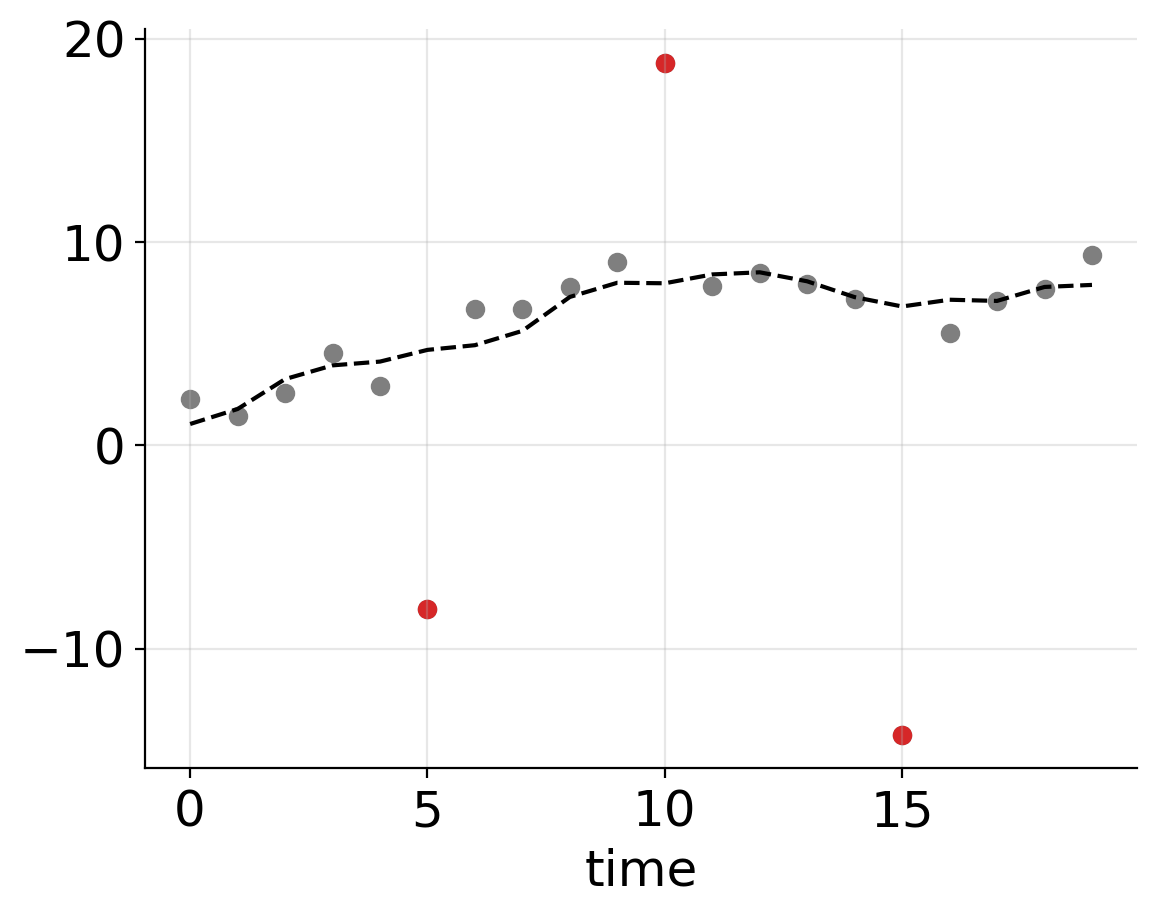

In [154]:
plt.plot(y, c="tab:gray", label="measurement", marker="o", linewidth=0, zorder=0)
plt.plot(state[:, ix], c="black", linestyle="--", label="state")
plt.scatter(xout, yout, c="tab:red")
plt.grid(alpha=0.3)
plt.xlabel("time")

In [155]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)

init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

bel, filter_noisy = agent_kf.scan(
    init_bel, measurements, dgen.projection_matrix,
    callbacks.get_updated_mean
)


bel, filter_clean = agent_kf.scan(
    init_bel, measurements_clean, dgen.projection_matrix,
    callbacks.get_updated_mean
)

Text(0.5, 0, 'time')

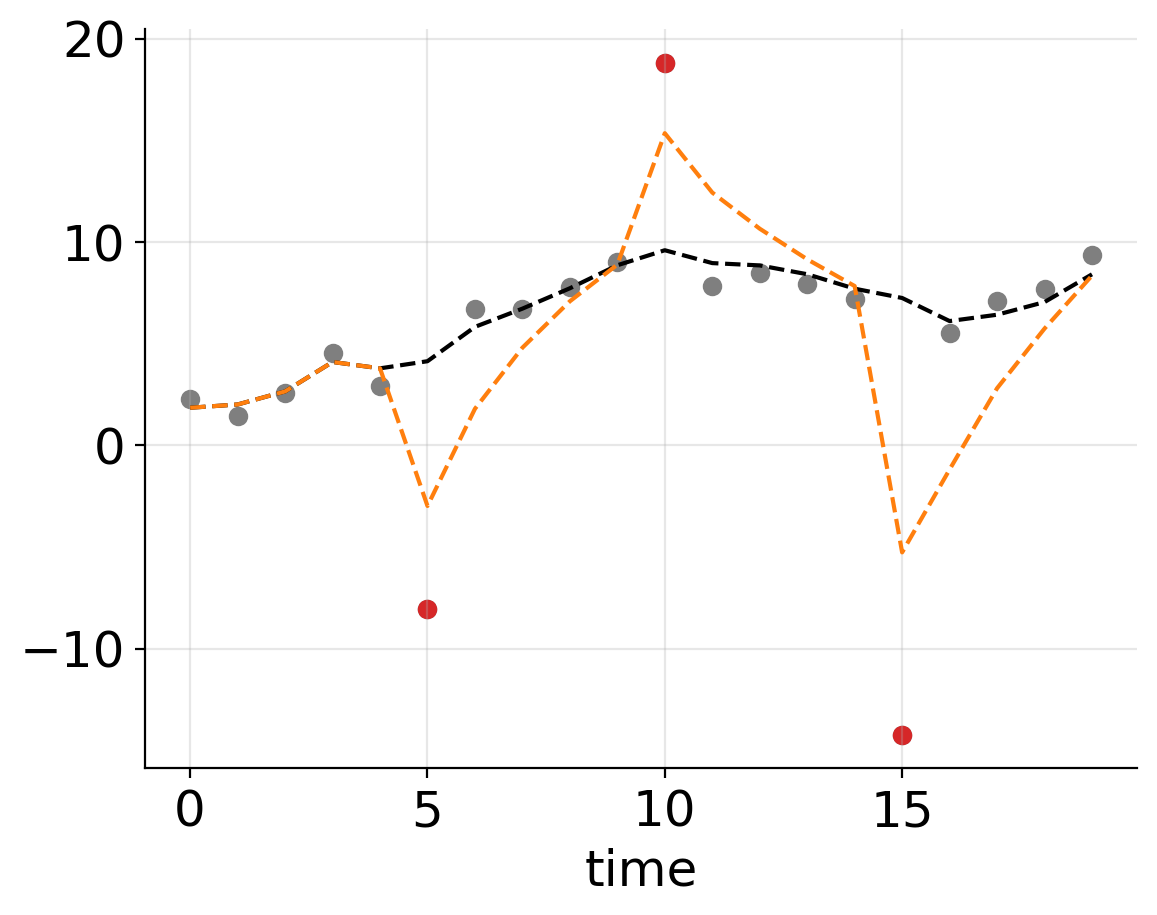

In [156]:
plt.plot(y, c="tab:gray", label="measurement", marker="o", linewidth=0, zorder=0)
plt.plot(filter_clean[:, ix], c="black", linestyle="--", label="state")
plt.plot(filter_noisy[:, ix], c="tab:orange", linestyle="--", label="state")

plt.scatter(xout, yout, c="tab:red")
plt.grid(alpha=0.3)
plt.xlabel("time")

## IMQ filter

In [157]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


In [158]:
soft_threshold = 2.5

agent_imq = gbf.IMQFilter(
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=soft_threshold,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
_, hist = agent_imq.scan(init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean)

In [191]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.linewidth"] = 3

In [199]:
fig.get_figwidth(), fig.get_figheight()

(6.4, 4.8)

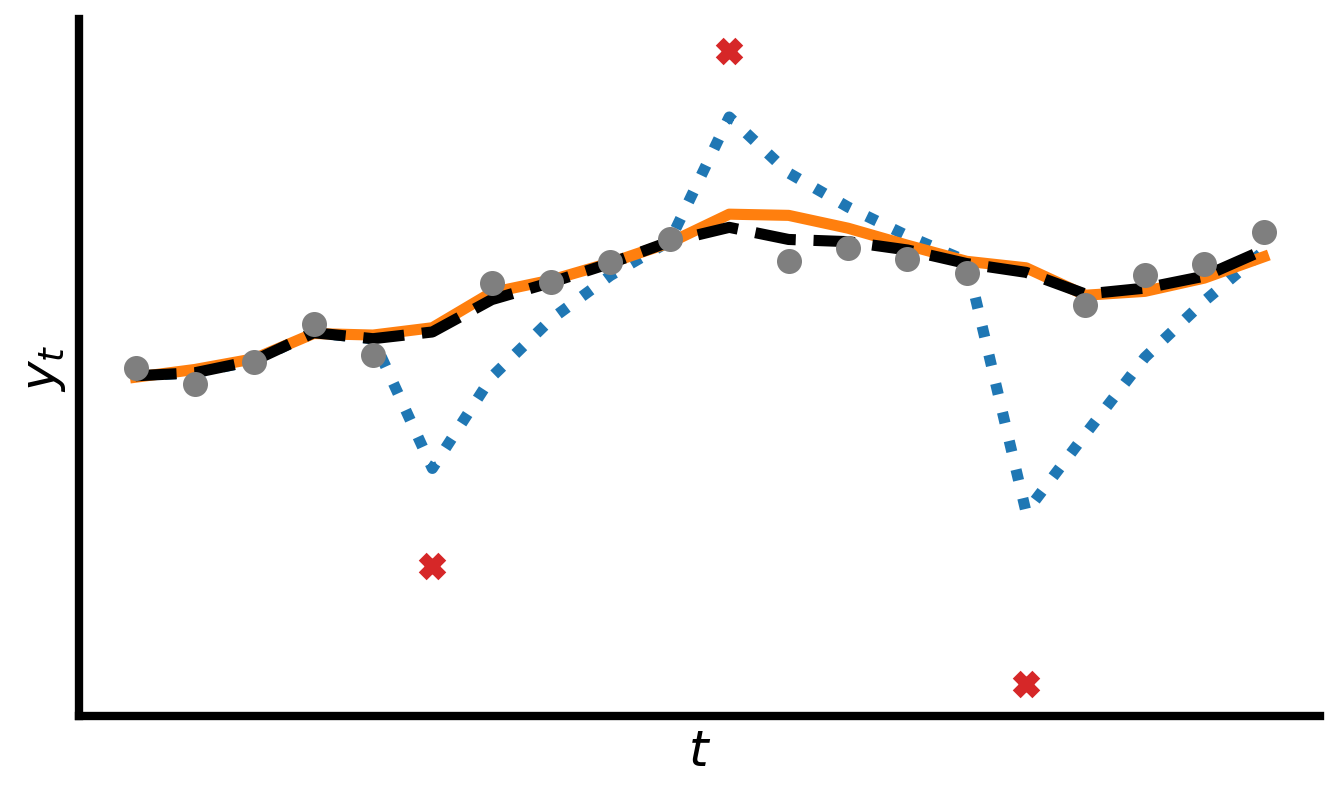

In [206]:
lw = 4
fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8 * 0.9))
plt.plot(filter_noisy[:, ix], c="C0", label="KF", linewidth=lw, linestyle="dotted")
plt.plot(hist[:, ix], c="C1", label="WLF", linewidth=lw)
plt.plot(filter_clean[:, ix], c="black", linestyle="--", label="KF-clean", linewidth=lw)

plt.plot(xrange[~is_outlier], y[~is_outlier], c="tab:gray", marker="o", linewidth=0, markersize=8)
plt.scatter(xout, yout, c="tab:red", zorder=3, s=50, marker="x", linewidth=4)

# plt.grid(alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.ylabel("$y_t$")
plt.xlabel("$t$")
plt.tight_layout()
plt.savefig("./figures/intro-plot.png", dpi=300)
# plt.legend(loc="upper left", fontsize=13)